In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [784, 500, 10]
model = EP(architecture, activation = activation)

In [5]:
lrs = [0.05, 0.025]

In [6]:
optim_params = []
for idx in range(len(model.W)):
    optim_params.append(  {'params': model.W[idx].parameters(), 'lr': lrs[idx]}  )

In [7]:
optimizer = torch.optim.SGD( optim_params, momentum=0.0 )

In [8]:
model = model.to(device)
evaluateEP(model, test_loader, 20, 0.5, device)

Test accuracy :	 0.0819


0.0819

In [9]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5
train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train();

In [10]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 25
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas
        
        for _ in range(T2):
            neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
            neurons_2 = copy(neurons)
            model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, criterion)
            optimizer.step() 
            neurons_1 = neurons_2
    trn_acc = evaluateEP(model.to(device), train_loader, T1, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, T1, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [04:21, 11.46it/s]
1it [00:00,  9.53it/s]

Epoch : 1, Train Accuracy : 0.9388666666666666, Test Accuracy : 0.9374


3000it [03:51, 12.98it/s]
1it [00:00,  9.79it/s]

Epoch : 2, Train Accuracy : 0.9518, Test Accuracy : 0.9471


3000it [04:11, 11.91it/s]
2it [00:00, 12.31it/s]

Epoch : 3, Train Accuracy : 0.95875, Test Accuracy : 0.9493


3000it [03:56, 12.68it/s]
2it [00:00, 10.79it/s]

Epoch : 4, Train Accuracy : 0.9653166666666667, Test Accuracy : 0.9556


1295it [01:59, 10.87it/s]


KeyboardInterrupt: 

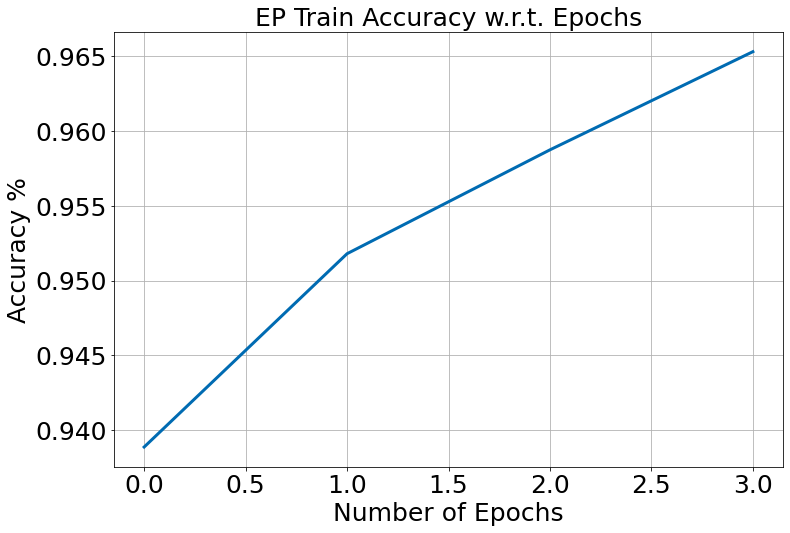

In [11]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

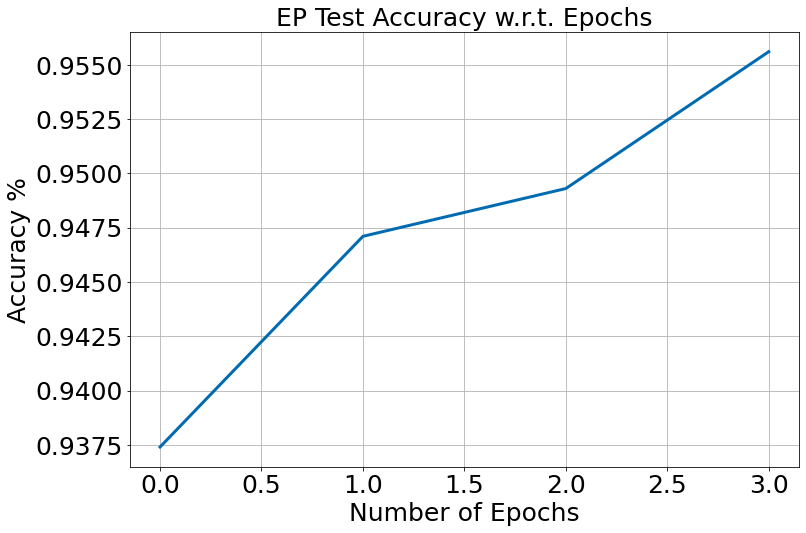

In [12]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [13]:
evaluateEP(model.to(device), test_loader, T1, neural_lr, device)

Test accuracy :	 0.9563


0.9563

In [14]:
evaluateEP(model.to(device), train_loader, T1, neural_lr, device)

Train accuracy :	 0.9642333333333334


0.9642333333333334